#Proyecto final de Computación Evolutiva - "Usando computación evolutiva para asignación de ítems a bins "

In [94]:
import random as rand
import numpy as np
from tabulate import tabulate
from random import shuffle, random, sample, randint, randrange, uniform

##Definiendo clase Item

In [95]:
class Item:
    def __init__(self, weight):
        self.weight = weight # Peso del item. Se impone una restriccion en el peso maximo de un bin

##Definiendo clase Candidate

In [96]:
class Candidate:
    def __init__(self, bins, population, peso_maximo,ItemPool, chromosome=None):
        self.bins = bins 
        self.population = population
        self.peso_maximo = peso_maximo
        self.ItemPool = ItemPool
        
        if chromosome is None:
            #Generación aleatorio de cromosoma            
            self.chromosome = np.random.randint(low=0, high=self.bins+1, size=len(self.ItemPool))
        else:
            self.chromosome = chromosome
            
        self.fitness = self.calculate_fitness()
        
    def calculate_fitness(self):
        
        bin_weights = {}
        for n in range(self.bins+1):
          bin_weights[n] = 0  
        for idx, allocation in enumerate(self.chromosome):                          
            bin_weights[allocation] += self.ItemPool[idx].weight
        
        sum=0
        for bin in bin_weights:
          if  bin ==0:
            sum += bin_weights[bin]
          elif bin_weights[bin]>self.peso_maximo:
            return 10000 #Hard constraint
          else:
            sum += self.peso_maximo-bin_weights[bin]
        return sum
    
    def m_gene_mutation(self):
        # operador tipo flip
        choose_gene = rand.randint(0, len(self.chromosome)-1)
        self.chromosome[choose_gene] = rand.randint(1,self.bins)

        
    def m_gene_mutation_multiflip(self):
        """
        Cambia los alelos de un conjunto de genes escogidos aleatoriamente (hasta un maximo de 50% de genes).
        """
        new_chromosome = self.chromosome[:]
        chromosome_len = len(new_chromosome)
        ix_to_mutate = np.random.choice(chromosome_len, chromosome_len // 2, replace=False) #retorna lista de indices que representan el 50% de genes
        for ix in ix_to_mutate:
          new_chromosome[ix] = rand.randint(1,self.bins) 
        self.chromosome = new_chromosome

   

##Operadores de cruzamiento

In [97]:
def single_point_crossover(parent_a,parent_b):
    crossover_point = rand.randint(1, len(parent_a)-2)
    parent_a_start, parent_a_end = parent_a[:crossover_point], parent_a[crossover_point:]
    parent_b_start, parent_b_end = parent_b[:crossover_point], parent_b[crossover_point:]
    child_a = np.hstack((parent_a_start, parent_b_end))
    child_b = np.hstack((parent_a_end, parent_b_start))
    return child_a, child_b

def uniform_crossover(parent_a, parent_b):
    chromosome1 = []
    chromosome2 = []
    "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
    for i in range(len(parent_a)):
      if uniform(0, 1) < 0.5 :
         chromosome1.append(parent_a[i])
         chromosome2.append(parent_b[i])
      else:
         chromosome1.append(parent_b[i])
         chromosome2.append(parent_a[i])
    parent_a = np.array(chromosome1)
    parent_b = np.array(chromosome2)
    return parent_a, parent_b 


##Método Tournament y Weakest replacement

In [98]:

def binary_tournament(population):
    #Selección de 2 candidatos
    candidates = np.random.choice(population, 2, replace=False)
    #Retorna el de menor fitness
    return min(candidates, key=lambda candidate: candidate.fitness)

def weakest_replacement(population, candidate):
    #Encuentra la solución más subóptima
    worst_solution = min(population, key=lambda solution: solution.fitness)
    if candidate.fitness <= worst_solution.fitness:
        population.remove(worst_solution)
        population.append(candidate)
    return population



##Método que dispara AG

In [99]:

def solve_bin(bins,m,cross_type, mut_type, population,peso_maximo,ItemPool,generation, crossover=True,):
    #Inicializando población
    pop = [Candidate(bins=bins,peso_maximo=peso_maximo,ItemPool=ItemPool,population=population) for _ in range(population)]
    lst_hist_fitness = []
    for g in range(generation):
       for i in range(int(population)): 
          #Selección de padres
          parent_a, parent_b = binary_tournament(pop), binary_tournament(pop)
          if crossover:   
              if cross_type == "onepoint":
                  child_a, child_b = single_point_crossover(parent_a.chromosome,parent_b.chromosome)
              elif cross_type == "uniform":
                  child_a, child_b = uniform_crossover(parent_a.chromosome,parent_b.chromosome)
              else:
                  raise NotImplementedError
              
          else:
              child_a, child_b = parent_a.chromosome[:], parent_b.chromosome[:]

          #Creación de offspring
          child_a = Candidate(bins=bins, peso_maximo=peso_maximo,population=population,ItemPool=ItemPool, chromosome = child_a)
          child_b = Candidate(bins=bins, peso_maximo=peso_maximo,population=population,ItemPool=ItemPool, chromosome = child_b)
          
          #Mutación
          if m != 0:

              if uniform(0, 1) < m: 
                if mut_type == "flip":
                  child_a.m_gene_mutation()
                  child_b.m_gene_mutation()
                elif mut_type == "multiflip":
                  child_a.m_gene_mutation_multiflip()
                  child_b.m_gene_mutation_multiflip()
                else:
                  raise NotImplementedError
      
              child_a.fitness= child_a.calculate_fitness()
              child_b.fitness = child_b.calculate_fitness()
          #Evaluando si nuevo offspring reemplazará a una solución existente subóptima
          pop = weakest_replacement(pop, child_a)
          pop = weakest_replacement(pop, child_b)
       lst_hist_fitness.append(min(pop, key=lambda solution: solution.fitness).fitness)
    best_candidate = min(pop, key=lambda solution: solution.fitness)
    best_fitness = best_candidate.fitness
    best_chromosome = best_candidate.chromosome
    return  best_fitness, best_chromosome,lst_hist_fitness  

##Metodo ejecución de trials de AG

In [100]:
def run_trial(trial_name,bins,mutation,crossover, population,n_trials,peso_maximo, ItemPool,generation, cross_type, mut_type ):
    fitness_lst = []
    chromosome_lst =[]
    hist_fitness_lst =[]
    for n in range(n_trials):
        print("Corriendo Trial", trial_name, ": ", n+1 , "/", n_trials)
        rand.seed(n)
        np.random.seed(n)        
        fitness, chromosome, hist_fitness = solve_bin(bins, mutation,cross_type, mut_type, population, peso_maximo,ItemPool,generation, crossover=crossover)
        fitness_lst.append(fitness)
        chromosome_lst.append(chromosome)
        hist_fitness_lst.append(hist_fitness)
    return fitness_lst, chromosome_lst, hist_fitness_lst
    
    

##EJECUCION DE ALGORITMO

In [101]:
NUM_BINS = 5
NUM_POPULATION = 30       # numero de items
NUM_ITEMS = 10     # numero de items
MAX_ITEM_WEIGHT = 150  # maximo peso posible de cada  item
NUM_TRIALS = 10
NUM_GENERATION = 100
#pool de items generado aleatoriamente


In [102]:
ItemPool = [ Item(randint(1,MAX_ITEM_WEIGHT)) for x in range (0,NUM_ITEMS)]


###Primer segmento de ejecuciones

In [103]:
bpp1_results = [[] for x in range(14)]
bpp1_results[0] = run_trial("Crossover OnePoint and M0",NUM_BINS, 0, True,NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='flip')
bpp1_results[1] = run_trial("Crossover Uniform and M0",NUM_BINS, 0, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform', mut_type='flip')
bpp1_results[2] = run_trial("Crossover OnePoint and M1 flip", NUM_BINS, 0.1, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint', mut_type='flip')
bpp1_results[3] = run_trial("Crossover OnePoint and M3 flip", NUM_BINS, 0.3, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint', mut_type='flip')
bpp1_results[4] = run_trial("Crossover OnePoint and M5 flip", NUM_BINS, 0.5, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='flip')
bpp1_results[5] = run_trial("Crossover OnePoint and M8 flip", NUM_BINS, 0.8, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='flip')
bpp1_results[6] = run_trial("Crossover Uniform and M1 flip", NUM_BINS, 0.1, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='flip',)
bpp1_results[7] = run_trial("Crossover Uniform and M3 flip", NUM_BINS, 0.3, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='flip',)
bpp1_results[8] = run_trial("Crossover Uniform and M5 flip", NUM_BINS, 0.5, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='flip',)
bpp1_results[9] = run_trial("Crossover Uniform and M8 flip", NUM_BINS, 0.8, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='flip',)
bpp1_results[10] = run_trial("No Crossover M1 flip", NUM_BINS, 0.1, False,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='flip',)
bpp1_results[11] = run_trial("No Crossover M3 flip", NUM_BINS, 0.3, False,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='flip',)
bpp1_results[12] = run_trial("No Crossover M5 flip", NUM_BINS, 0.5, False,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='flip',)
bpp1_results[13] = run_trial("No Crossover M8 flip", NUM_BINS, 0.8, False,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='flip',)


Corriendo Trial Crossover OnePoint and M0 :  1 / 10
Corriendo Trial Crossover OnePoint and M0 :  2 / 10
Corriendo Trial Crossover OnePoint and M0 :  3 / 10
Corriendo Trial Crossover OnePoint and M0 :  4 / 10
Corriendo Trial Crossover OnePoint and M0 :  5 / 10
Corriendo Trial Crossover OnePoint and M0 :  6 / 10
Corriendo Trial Crossover OnePoint and M0 :  7 / 10
Corriendo Trial Crossover OnePoint and M0 :  8 / 10
Corriendo Trial Crossover OnePoint and M0 :  9 / 10
Corriendo Trial Crossover OnePoint and M0 :  10 / 10
Corriendo Trial Crossover Uniform and M0 :  1 / 10
Corriendo Trial Crossover Uniform and M0 :  2 / 10
Corriendo Trial Crossover Uniform and M0 :  3 / 10
Corriendo Trial Crossover Uniform and M0 :  4 / 10
Corriendo Trial Crossover Uniform and M0 :  5 / 10
Corriendo Trial Crossover Uniform and M0 :  6 / 10
Corriendo Trial Crossover Uniform and M0 :  7 / 10
Corriendo Trial Crossover Uniform and M0 :  8 / 10
Corriendo Trial Crossover Uniform and M0 :  9 / 10
Corriendo Trial Cros

###Segundo segmento de ejecuciones

In [104]:
bpp2_results = [[] for x in range(14)]
bpp2_results[0] = run_trial("Crossover OnePoint and M1 multiflip", NUM_BINS, 0.1, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint', mut_type='multiflip')
bpp2_results[1] = run_trial("Crossover OnePoint and M3 multiflip", NUM_BINS, 0.3, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint', mut_type='multiflip')
bpp2_results[2] = run_trial("Crossover OnePoint and M5 multiflip", NUM_BINS, 0.5, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='multiflip')
bpp2_results[3] = run_trial("Crossover OnePoint and M8 multiflip", NUM_BINS, 0.8, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='multiflip')
bpp2_results[4] = run_trial("Crossover Uniform and M1 multiflip", NUM_BINS, 0.1, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='multiflip',)
bpp2_results[5] = run_trial("Crossover Uniform and M3 multiflip", NUM_BINS, 0.3, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='multiflip',)
bpp2_results[6] = run_trial("Crossover Uniform and M5 multiflip", NUM_BINS, 0.5, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='multiflip',)
bpp2_results[7] = run_trial("Crossover Uniform and M8 multiflip", NUM_BINS, 0.8, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='multiflip',)
bpp2_results[8] = run_trial("No Crossover M1 multiflip", NUM_BINS, 0.1, False,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='multiflip',)
bpp2_results[9] = run_trial("No Crossover M3 multiflip", NUM_BINS, 0.3, False,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='multiflip',)
bpp2_results[10] = run_trial("No Crossover M5 multiflip", NUM_BINS, 0.5, False,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='multiflip',)
bpp2_results[11] = run_trial("No Crossover M8 multiflip", NUM_BINS, 0.8, False,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='multiflip',)


Corriendo Trial Crossover OnePoint and M1 multiflip :  1 / 10
Corriendo Trial Crossover OnePoint and M1 multiflip :  2 / 10
Corriendo Trial Crossover OnePoint and M1 multiflip :  3 / 10
Corriendo Trial Crossover OnePoint and M1 multiflip :  4 / 10
Corriendo Trial Crossover OnePoint and M1 multiflip :  5 / 10
Corriendo Trial Crossover OnePoint and M1 multiflip :  6 / 10
Corriendo Trial Crossover OnePoint and M1 multiflip :  7 / 10
Corriendo Trial Crossover OnePoint and M1 multiflip :  8 / 10
Corriendo Trial Crossover OnePoint and M1 multiflip :  9 / 10
Corriendo Trial Crossover OnePoint and M1 multiflip :  10 / 10
Corriendo Trial Crossover OnePoint and M3 multiflip :  1 / 10
Corriendo Trial Crossover OnePoint and M3 multiflip :  2 / 10
Corriendo Trial Crossover OnePoint and M3 multiflip :  3 / 10
Corriendo Trial Crossover OnePoint and M3 multiflip :  4 / 10
Corriendo Trial Crossover OnePoint and M3 multiflip :  5 / 10
Corriendo Trial Crossover OnePoint and M3 multiflip :  6 / 10
Corrien

###Evaluando resultados de primer segmento

In [105]:
header = ["Problem 1","Trial 1","Trial 2","Trial 3","Trial 4","Trial 5","Trial 6", "Trial 7", "Trial 8", "Trial 9", "Trial 10" ,"Average" ]
table1 = ([["Crossover OnePoint and M0", *bpp1_results[0][0], sum(bpp1_results[0][0])/NUM_TRIALS],
          ["Crossover Uniform and M0", *bpp1_results[1][0], sum(bpp1_results[1][0])/NUM_TRIALS],
          ["Crossover OnePoint and M1 flip", *bpp1_results[2][0], sum(bpp1_results[2][0])/NUM_TRIALS],
          ["Crossover OnePoint and M3 flip", *bpp1_results[3][0], sum(bpp1_results[3][0])/NUM_TRIALS],
          ["Crossover OnePoint and M5 flip", *bpp1_results[4][0], sum(bpp1_results[4][0])/NUM_TRIALS],
          ["Crossover OnePoint and M8 flip", *bpp1_results[5][0], sum(bpp1_results[5][0])/NUM_TRIALS],
          ["Crossover Uniform and M1 flip", *bpp1_results[6][0], sum(bpp1_results[6][0])/NUM_TRIALS],
          ["Crossover Uniform and M3 flip", *bpp1_results[7][0], sum(bpp1_results[7][0])/NUM_TRIALS],
          ["Crossover Uniform and M5 flip", *bpp1_results[8][0], sum(bpp1_results[8][0])/NUM_TRIALS],
          ["Crossover Uniform and M8 flip", *bpp1_results[9][0], sum(bpp1_results[9][0])/NUM_TRIALS],
          ["No Crossover M1 flip", *bpp1_results[10][0], sum(bpp1_results[10][0])/NUM_TRIALS],
          ["No Crossover M3 flip", *bpp1_results[11][0], sum(bpp1_results[11][0])/NUM_TRIALS],
          ["No Crossover M5 flip", *bpp1_results[12][0], sum(bpp1_results[12][0])/NUM_TRIALS],
          ["No Crossover M8 flip", *bpp1_results[13][0], sum(bpp1_results[13][0])/NUM_TRIALS],
          ]
         )
print(tabulate(table1, headers=header))
print("--------------------------------------------------------------------------------------------------------------------")
           

Problem 1                         Trial 1    Trial 2    Trial 3    Trial 4    Trial 5    Trial 6    Trial 7    Trial 8    Trial 9    Trial 10    Average
------------------------------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ----------  ---------
Crossover OnePoint and M0              47         93        173        199        199         47         47        163        199          47      121.4
Crossover Uniform and M0               99         93        163      10000        163         47        173        199        225          47     1120.9
Crossover OnePoint and M1 flip        217        199        173        219         47         99        163        173         93         199      158.2
Crossover OnePoint and M3 flip         93         93        163        199        199         47        163         47         47          47      109.8
Crossover OnePoint and M5 flip         47         99        163        199        

###Evaluando resultados de segundo segmento

In [106]:
header = ["Problem 1","Trial 1","Trial 2","Trial 3","Trial 4","Trial 5","Trial 6", "Trial 7", "Trial 8", "Trial 9", "Trial 10" ,"Average" ]
table2 = ([
          ["Crossover OnePoint and M1 multiflip", *bpp2_results[0][0], sum(bpp2_results[0][0])/NUM_TRIALS],
          ["Crossover OnePoint and M3 multiflip", *bpp2_results[1][0], sum(bpp2_results[1][0])/NUM_TRIALS],
          ["Crossover OnePoint and M5 multiflip", *bpp2_results[2][0], sum(bpp2_results[2][0])/NUM_TRIALS],
          ["Crossover OnePoint and M8 multiflip", *bpp2_results[3][0], sum(bpp2_results[3][0])/NUM_TRIALS],
          ["Crossover Uniform and M1 multiflip", *bpp2_results[4][0], sum(bpp2_results[4][0])/NUM_TRIALS],
          ["Crossover Uniform and M3 multiflip", *bpp2_results[5][0], sum(bpp2_results[5][0])/NUM_TRIALS],
          ["Crossover Uniform and M5 multiflip", *bpp2_results[6][0], sum(bpp2_results[6][0])/NUM_TRIALS],
          ["Crossover Uniform and M8 multiflip", *bpp2_results[7][0], sum(bpp2_results[7][0])/NUM_TRIALS],
          ["No Crossover M1 multiflip", *bpp2_results[8][0], sum(bpp2_results[8][0])/NUM_TRIALS],
          ["No Crossover M3 multiflip", *bpp2_results[9][0], sum(bpp2_results[9][0])/NUM_TRIALS],
          ["No Crossover M5 multiflip", *bpp2_results[10][0], sum(bpp2_results[10][0])/NUM_TRIALS],
          ["No Crossover M8 multiflip", *bpp2_results[11][0], sum(bpp2_results[11][0])/NUM_TRIALS],
          ]
         )
print(tabulate(table2, headers=header))
print("--------")

Problem 1                              Trial 1    Trial 2    Trial 3    Trial 4    Trial 5    Trial 6    Trial 7    Trial 8    Trial 9    Trial 10    Average
-----------------------------------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ----------  ---------
Crossover OnePoint and M1 multiflip        163        173        173         47         47         47        199         99         93          47      108.8
Crossover OnePoint and M3 multiflip        145         47        173      10000      10000         47        199        173         93          93     2097
Crossover OnePoint and M5 multiflip         93         93        163        163         47         47         93        217         93          47      105.6
Crossover OnePoint and M8 multiflip        139      10000         93      10000         47         47         93        173         47          93     2073.2
Crossover Uniform and M1 multiflip          47        

##RESULTADOS (Ejecución manual)

*Hecho manualmente

### TABLA TOP 3 MEJOR AVG

In [107]:
#all results
header = ["Mejores operadores","Trial 1","Trial 2","Trial 3","Trial 4","Trial 5","Trial 6", "Trial 7", "Trial 8", "Trial 9", "Trial 10" ,"Average" ]
table2 = ([
          ["Crossover OnePoint and M3 flip ", *bpp1_results[3][0], sum(bpp1_results[3][0])/NUM_TRIALS],
          ["Crossover Uniform and M1 multiflip", *bpp2_results[4][0], sum(bpp2_results[4][0])/NUM_TRIALS],
          ["Crossover OnePoint and M0", *bpp1_results[0][0], sum(bpp1_results[0][0])/NUM_TRIALS],
         
          ]
         )
print(tabulate(table2, headers=header))
print("--------")

Mejores operadores                    Trial 1    Trial 2    Trial 3    Trial 4    Trial 5    Trial 6    Trial 7    Trial 8    Trial 9    Trial 10    Average
----------------------------------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ----------  ---------
Crossover OnePoint and M3 flip             93         93        163        199        199         47        163         47         47          47      109.8
Crossover Uniform and M1 multiflip         47        163         47        163         99         47        163         47        199          47      102.2
Crossover OnePoint and M0                  47         93        173        199        199         47         47        163        199          47      121.4
--------


"#Mejores combinaciones encontradas

* Crossover OnePoint and M3 flip  = avg => 234 (199 - Trial 6)




* Crossover Uniform and M1 multiflip = avg => 242(199 Trial 5)

In [108]:
import matplotlib.pyplot as plt

###**GRAFICOS MEJOR RESULTADO**

**Crossover OnePoint and M3 flip  = avg => 234 (199 - Trial 6)**

**Mejor cromosoma**

In [109]:
best_result = bpp1_results[3]

In [110]:
best_result[1][5]

array([1, 3, 4, 2, 1, 5, 4, 3, 2, 4])

**Histograma de cromosoma con mejor fitness por generación**

Text(0.5, 1.0, 'Histograma de cromosoma con mejor fitness por generación')

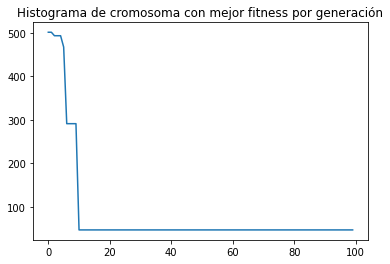

In [111]:
plt.plot(best_result[2][5])
plt.title("Histograma de cromosoma con mejor fitness por generación")

**Evolución de mejor fitness por trial de operador con mejores resultados**

Text(0.5, 1.0, 'Evolución de mejor fitness por trial de operador con mejores resultados')

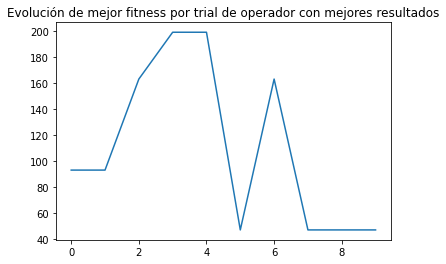

In [112]:
plt.plot(best_result[0])
plt.title("Evolución de mejor fitness por trial de operador con mejores resultados")

**Generación en la que se encontró el mejor fitness por trial**

Text(0.5, 1.0, 'Generación en la que se encontró el mejor fitness por trial')

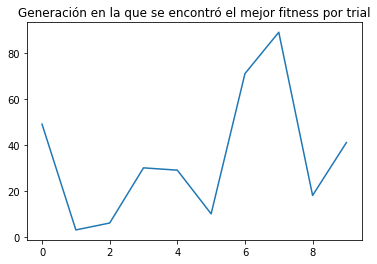

In [113]:
lst_grf = [ x.index(min(x)) for x in best_result[2]]
plt.plot(lst_grf)
plt.title("Generación en la que se encontró el mejor fitness por trial")

In [114]:
import pandas as pd
df_lst = []
for ix,x in enumerate(best_result[1][5]):
  df_lst.append({
      'item': ix + 1,
      'weight' : ItemPool[ix].weight,
      'bin' : x
  })
solucion = pd.DataFrame(df_lst)

**Dataset de distribución por bin y item**

In [115]:
solucion

,item,weight,bin
0,1,58,1
1,2,63,3
2,3,26,4
3,4,23,2
4,5,85,1
5,6,138,5
6,7,89,4
7,8,76,3
8,9,122,2
9,10,23,4


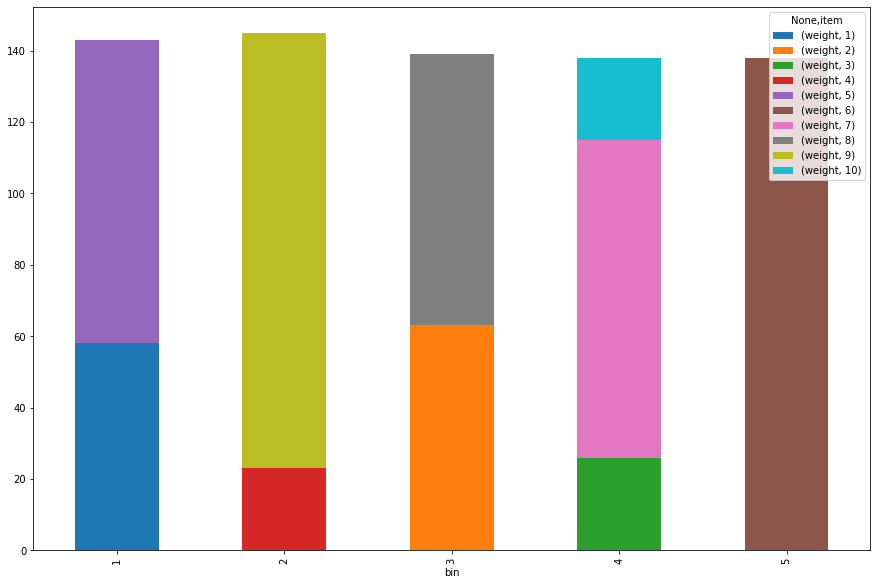

In [116]:
ax = solucion.groupby(['bin', 'item']).sum().unstack().plot(kind='bar', figsize=(15,10),stacked=True, legend=True)


###**GRAFICOS SEGUNDO MEJOR RESULTADO**

**Crossover Uniform and M1 multiflip = avg => 242(199 Trial 5)**

In [117]:
best_result = bpp2_results[4]

**Mejor cromosoma**

In [118]:
best_result[1][4]

array([2, 4, 0, 5, 4, 3, 5, 2, 1, 1])

**Histograma de evolución de fitness**

Text(0.5, 1.0, 'Histograma de cromosoma con mejor fitness por generación')

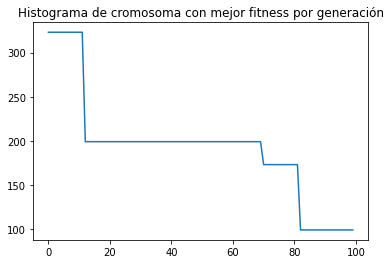

In [119]:
plt.plot(best_result[2][4])
plt.title("Histograma de cromosoma con mejor fitness por generación")

**Evolución de mejor fitness por trial**

Text(0.5, 1.0, 'Evolución de mejor fitness por trial de operador con mejores resultados')

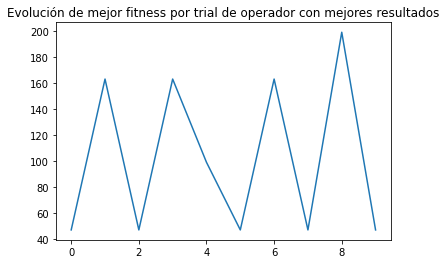

In [120]:
plt.plot(best_result[0])
plt.title("Evolución de mejor fitness por trial de operador con mejores resultados")

**Generación en la que se encontró el mejor fitness por trial**

Text(0.5, 1.0, 'Generación en la que se encontró el mejor fitness por trial')

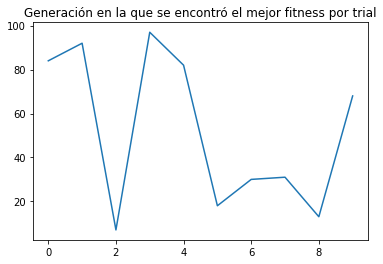

In [121]:
lst_grf = [ x.index(min(x)) for x in best_result[2]]
plt.plot(lst_grf)
plt.title("Generación en la que se encontró el mejor fitness por trial")

In [122]:
import pandas as pd
df_lst = []
for ix,x in enumerate(best_result[1][4]):
  df_lst.append({
      'item': ix + 1,
      'weight' : ItemPool[ix].weight,
      'bin' : x
  })
solucion = pd.DataFrame(df_lst)

**Dataset de distribución por bin y item**

In [123]:
solucion

,item,weight,bin
0,1,58,2
1,2,63,4
2,3,26,0
3,4,23,5
4,5,85,4
5,6,138,3
6,7,89,5
7,8,76,2
8,9,122,1
9,10,23,1


**Representación de bins**

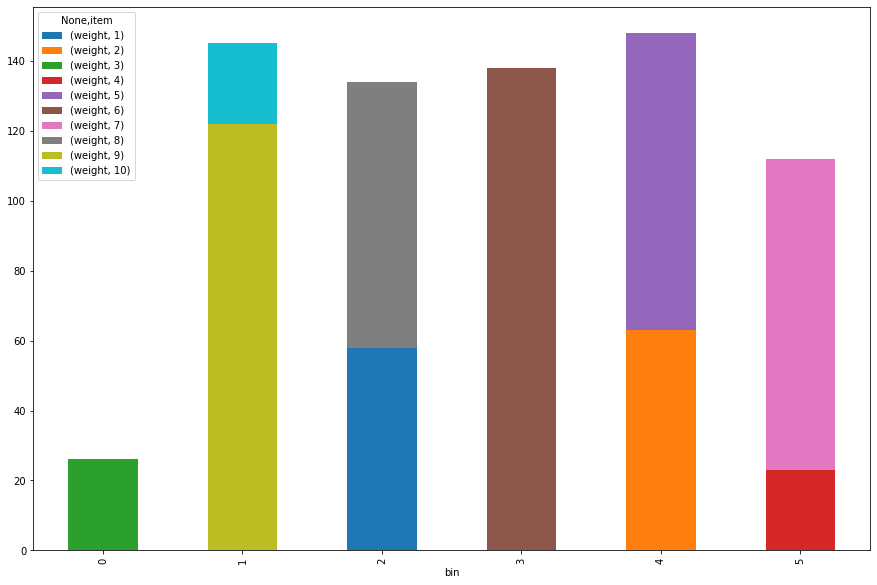

In [124]:
ax = solucion.groupby(['bin', 'item']).sum().unstack().plot(kind='bar', figsize=(15,10),stacked=True, legend=True)


##CASO DE USO  MODELO

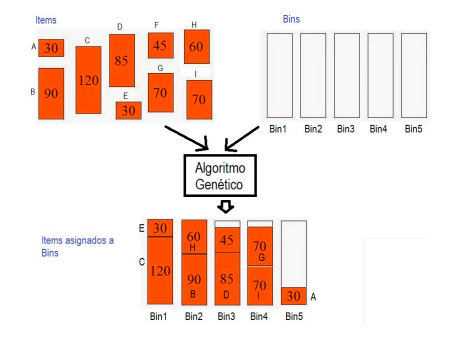

In [125]:
PESOS = [30,90,120,85,30,45,70,60,70]


In [126]:
NUM_BINS = 5
NUM_POPULATION = 30       # numero de items
NUM_ITEMS = 9     # numero de items
MAX_ITEM_WEIGHT = 150  # maximo peso posible de cada  item
NUM_TRIALS = 10
NUM_GENERATION = 100
#pool de items generado aleatoriamente


In [127]:
ItemPool = [ Item(x) for x in pesos]

In [128]:
bppx_results = [[] for x in range(5)]
bppx_results[0] = run_trial("Crossover OnePoint and M0",NUM_BINS, 0, True,NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='flip')
bppx_results[1] = run_trial("Crossover OnePoint and M1 flip", NUM_BINS, 0.1, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint', mut_type='flip')
bppx_results[2] = run_trial("Crossover OnePoint and M3 flip", NUM_BINS, 0.3, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint', mut_type='flip')
bppx_results[3] = run_trial("Crossover OnePoint and M5 flip", NUM_BINS, 0.5, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='flip')
bppx_results[4] = run_trial("Crossover Uniform and M1 multiflip", NUM_BINS, 0.1, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='multiflip',)


Corriendo Trial Crossover OnePoint and M0 :  1 / 10
Corriendo Trial Crossover OnePoint and M0 :  2 / 10
Corriendo Trial Crossover OnePoint and M0 :  3 / 10
Corriendo Trial Crossover OnePoint and M0 :  4 / 10
Corriendo Trial Crossover OnePoint and M0 :  5 / 10
Corriendo Trial Crossover OnePoint and M0 :  6 / 10
Corriendo Trial Crossover OnePoint and M0 :  7 / 10
Corriendo Trial Crossover OnePoint and M0 :  8 / 10
Corriendo Trial Crossover OnePoint and M0 :  9 / 10
Corriendo Trial Crossover OnePoint and M0 :  10 / 10
Corriendo Trial Crossover OnePoint and M1 flip :  1 / 10
Corriendo Trial Crossover OnePoint and M1 flip :  2 / 10
Corriendo Trial Crossover OnePoint and M1 flip :  3 / 10
Corriendo Trial Crossover OnePoint and M1 flip :  4 / 10
Corriendo Trial Crossover OnePoint and M1 flip :  5 / 10
Corriendo Trial Crossover OnePoint and M1 flip :  6 / 10
Corriendo Trial Crossover OnePoint and M1 flip :  7 / 10
Corriendo Trial Crossover OnePoint and M1 flip :  8 / 10
Corriendo Trial Crossov

In [129]:
header = ["Mejores operadores","Trial 1","Trial 2","Trial 3","Trial 4","Trial 5","Trial 6", "Trial 7", "Trial 8", "Trial 9", "Trial 10" ,"Average" ]
table3 = ([
            ["Crossover OnePoint and M0 ", *bppx_results[0][0], sum(bppx_results[0][0])/NUM_TRIALS],
            ["Crossover OnePoint and M1 flip", *bppx_results[1][0], sum(bppx_results[1][0])/NUM_TRIALS],
            ["Crossover OnePoint and M3 flip", *bppx_results[2][0], sum(bppx_results[2][0])/NUM_TRIALS],
            ["Crossover OnePoint and M5 flip", *bppx_results[3][0], sum(bppx_results[3][0])/NUM_TRIALS],
            ["Crossover Uniform and M1 multiflip", *bppx_results[4][0], sum(bppx_results[4][0])/NUM_TRIALS],
          ]
         )
print(tabulate(table3, headers=header))
print("--------")

Mejores operadores                    Trial 1    Trial 2    Trial 3    Trial 4    Trial 5    Trial 6    Trial 7    Trial 8    Trial 9    Trial 10    Average
----------------------------------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ----------  ---------
Crossover OnePoint and M0                 150        150        150        150        150        150        150        150        150         150        150
Crossover OnePoint and M1 flip            150        150        150        150        150        150        150        150        150         150        150
Crossover OnePoint and M3 flip            150        150        150        150        150        150        150        150        150         150        150
Crossover OnePoint and M5 flip            150        150        150        150        150        150        150        150        150         150        150
Crossover Uniform and M1 multiflip        150        150  

Text(0.5, 1.0, 'Histograma de cromosoma con mejor fitness por generación')

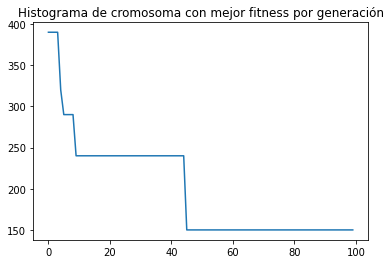

In [130]:
import matplotlib.pyplot as plt
plt.plot(bppx_results[0][2][0])
plt.title("Histograma de cromosoma con mejor fitness por generación")

In [131]:
bpx_list = [result.tolist() for result in bppx_results[0][1]]

In [132]:
bpx_list

[[4, 4, 3, 5, 2, 5, 1, 2, 1],
 [2, 2, 3, 5, 3, 5, 4, 4, 1],
 [5, 2, 4, 3, 4, 5, 1, 2, 1],
 [1, 5, 2, 4, 3, 1, 1, 4, 3],
 [5, 3, 4, 2, 4, 2, 1, 3, 5],
 [4, 3, 2, 1, 5, 3, 5, 1, 4],
 [1, 2, 3, 5, 5, 1, 4, 4, 1],
 [1, 1, 5, 2, 1, 4, 3, 2, 4],
 [1, 3, 2, 4, 2, 5, 1, 3, 5],
 [2, 3, 5, 1, 5, 2, 4, 4, 2]]

###Representación de soluciones propuestas

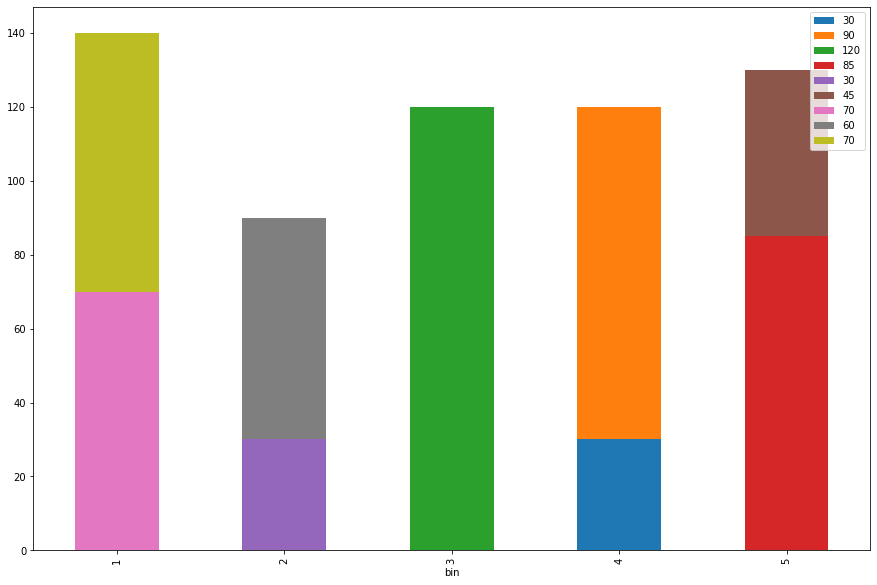

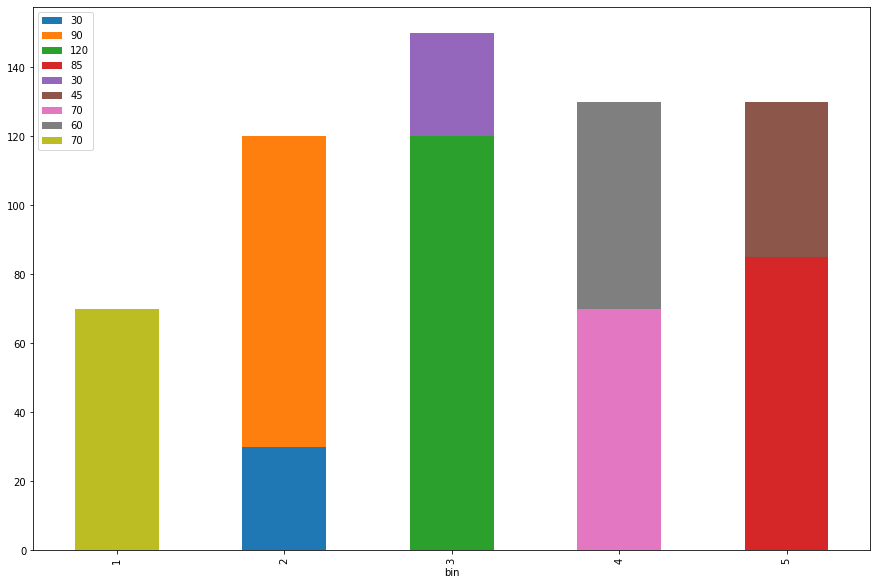

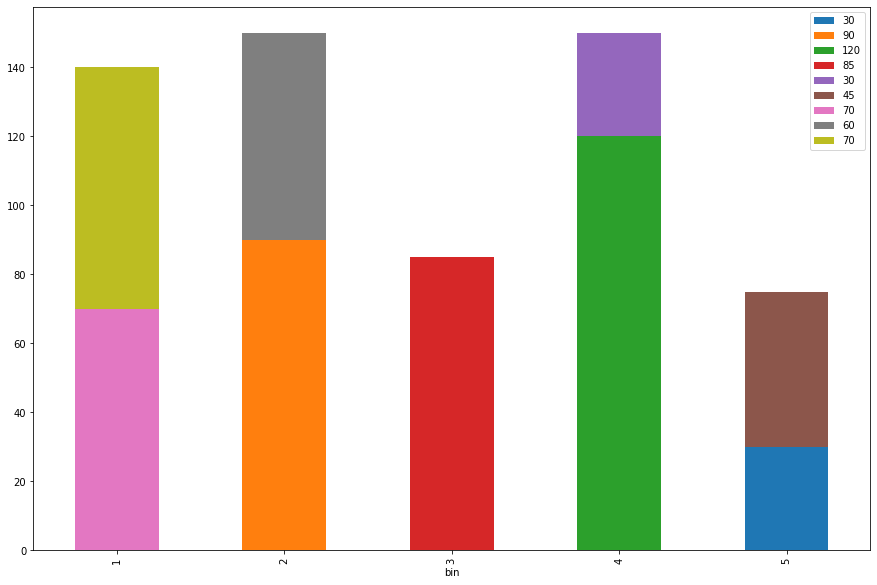

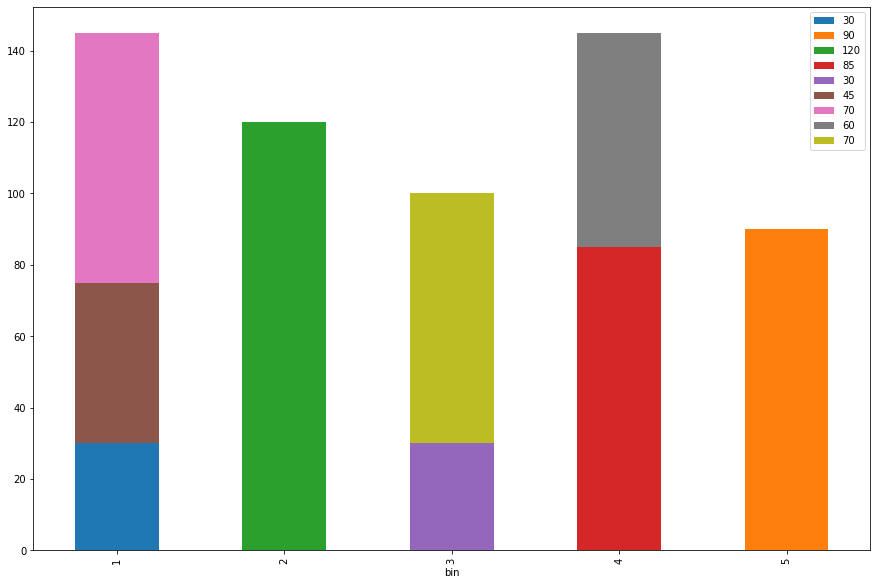

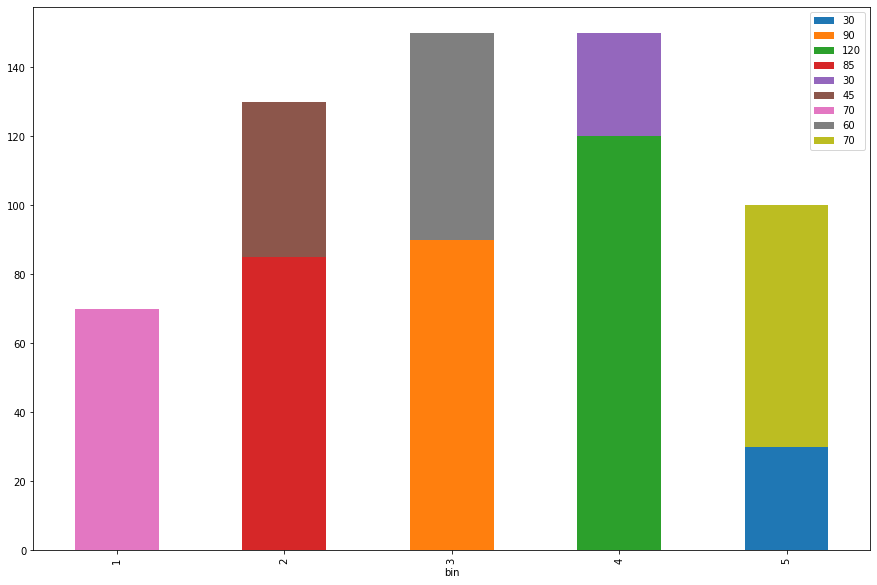

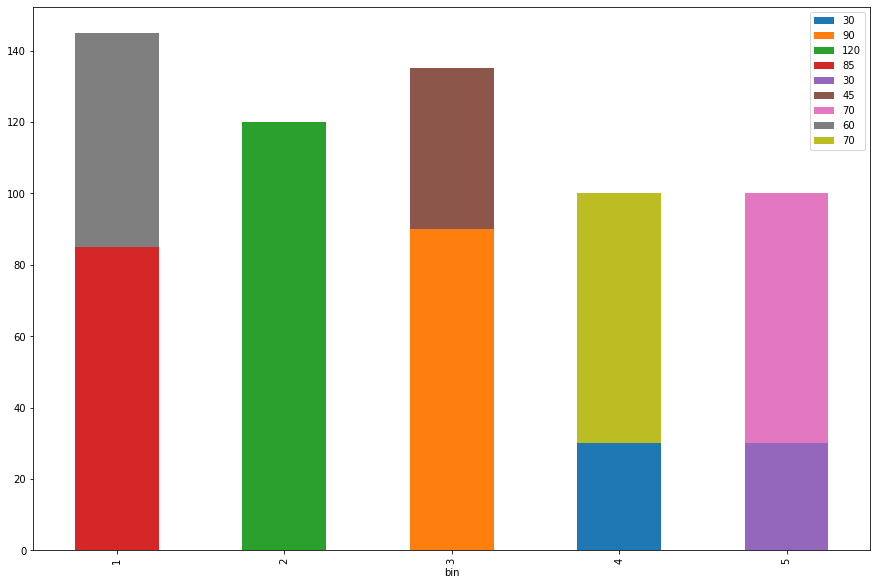

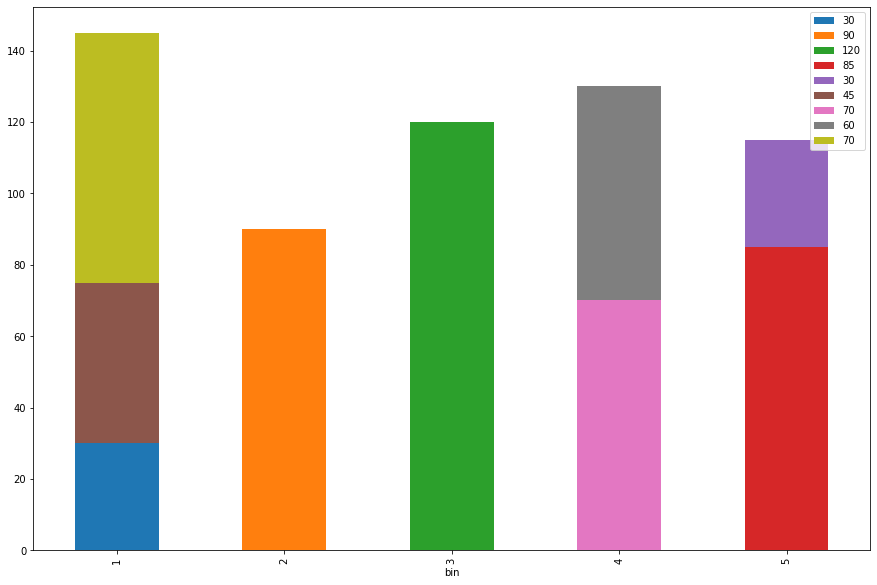

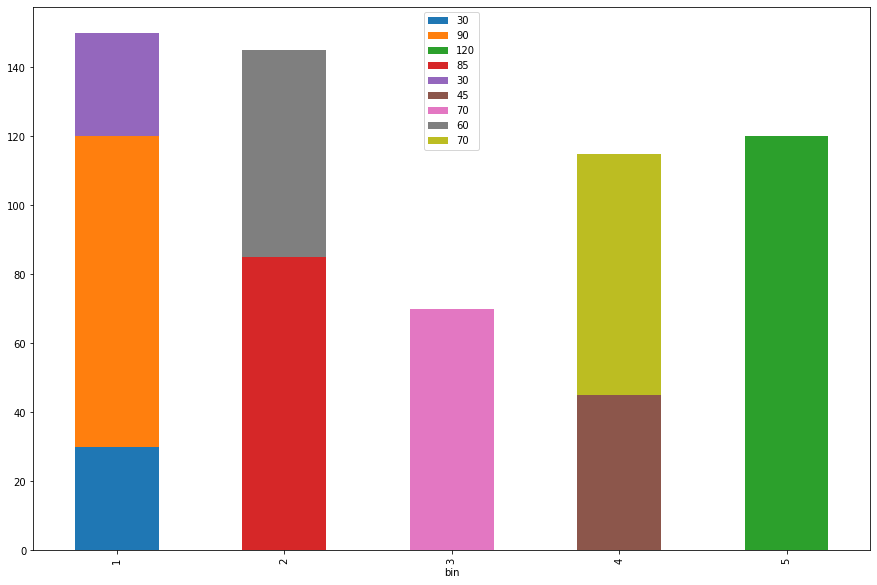

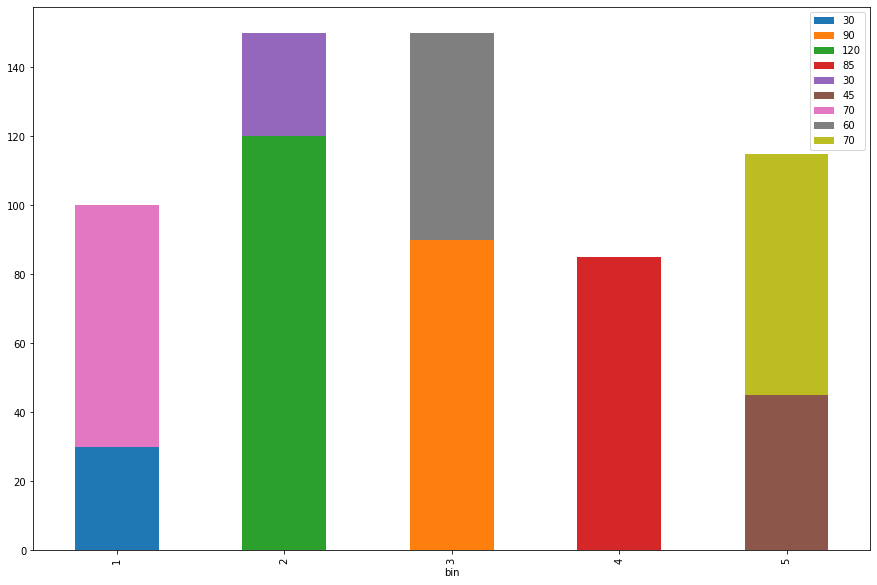

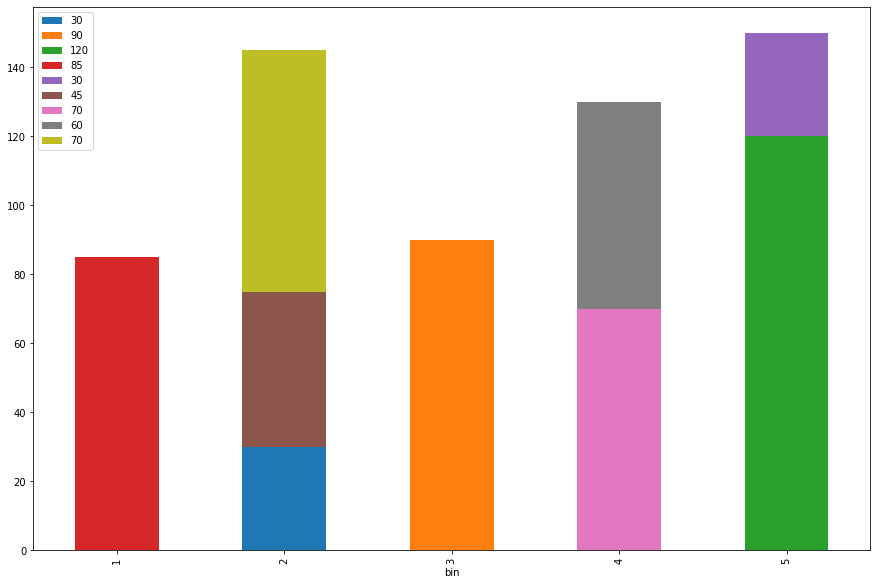

In [133]:
import pandas as pd

for chromosome in bpx_list:
  df_lst = []
  for ix,x in enumerate(chromosome):
    df_lst.append({
        'item': ix + 1,
        'weight' : ItemPool[ix].weight,
        'bin' : x
    })
  solucion = pd.DataFrame(df_lst)
  ax = solucion.groupby(['bin', 'item']).sum().unstack().plot(kind='bar', figsize=(15,10),stacked=True, legend=True)
  plt.legend(pesos)
    #print('x')

